1. learn.lr_find
2. working with tabular data
3. preprocessing

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surajjha96","key":"fbbbdadb1d757ce8e7a20bfdf79bdc5c"}'}

In [2]:
!pip install kaggle -Uqq
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json

In [3]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=100)
torch.set_printoptions(linewidth=100, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 100)

In [4]:
path = Path('titanic')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [6]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [7]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [8]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [9]:
df.columns,df.head(1)

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
        'Fare', 'Cabin', 'Embarked', 'LogFare'],
       dtype='object'),
    PassengerId  Survived  Pclass                     Name   Sex   Age  SibSp  Parch     Ticket  \
 0            1         0       3  Braund, Mr. Owen Harris  male  22.0      1      0  A/5 21171   
 
    Fare    Cabin Embarked   LogFare  
 0  7.25  B96 B98        S  2.110213  )

In [10]:
df.Sex,df.Sex.head(),df.Sex.cat.codes.head()

(0        male
 1      female
 2      female
 3      female
 4        male
         ...  
 886      male
 887    female
 888    female
 889      male
 890      male
 Name: Sex, Length: 891, dtype: category
 Categories (2, object): ['female', 'male'],
 0      male
 1    female
 2    female
 3    female
 4      male
 Name: Sex, dtype: category
 Categories (2, object): ['female', 'male'],
 0    1
 1    0
 2    0
 3    0
 4    1
 dtype: int8)

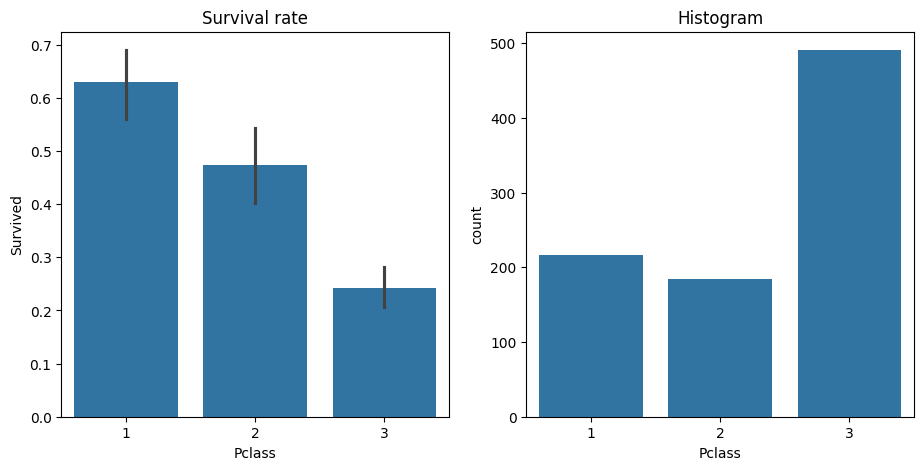

In [11]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Pclass", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Pclass", ax=axs[1]).set(title="Histogram");

In [12]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [13]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [14]:
#model1 -> just bsed on sex
preds = val_xs.Sex==0
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

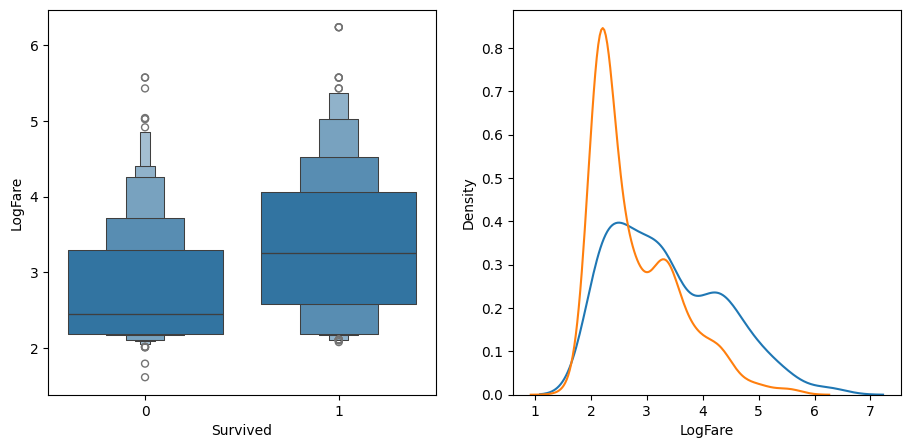

In [15]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare[df_fare['Survived']==1], x="LogFare", ax=axs[1]);
sns.kdeplot(data=df_fare[df_fare['Survived']==0], x="LogFare", ax=axs[1]);

In [16]:
#model2: more money -> survived
preds = val_xs.LogFare>2.7
mean_absolute_error(val_y, preds)

0.336322869955157

In [17]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

In [18]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (np.int8(0), np.float64(0.4078753098206398)),
 'Embarked': (np.int8(0), np.float64(0.478833425731479)),
 'Age': (np.float64(6.0), np.float64(0.47831671750899085)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817423)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736595)),
 'Pclass': (np.int64(2), np.float64(0.4604826188580666))}

In [19]:
# this shows Sex is the best split for this dataset

In [20]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [21]:
#split for males
{o:min_col(males, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.387558187041091)),
 'Age': (np.float64(6.0), np.float64(0.37398283710105873)),
 'SibSp': (np.int64(4), np.float64(0.38758642275862637)),
 'Parch': (np.int64(0), np.float64(0.3874704821461953)),
 'LogFare': (np.float64(2.803360380906535), np.float64(0.38048562317581447)),
 'Pclass': (np.int64(1), np.float64(0.3815544200436083))}

In [22]:
#Age , which is logical

In [23]:
#split for females
{o:min_col(females, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.4295252982857326)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431646)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713585)),
 'Parch': (np.int64(3), np.float64(0.4193314500446157)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.413505983329114)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567602))}

In [24]:
#Pclass for females.
#So males <6 or rich females

In [25]:
#using DT
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=20).fit(trn_xs, trn_y);
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

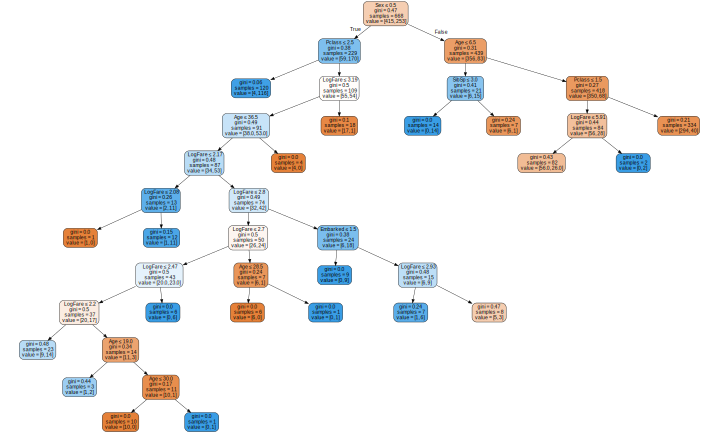

In [26]:
draw_tree(m, trn_xs, size=10)

In [27]:
mean_absolute_error(val_y, m.predict(val_xs))

0.17937219730941703

In [28]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

In [46]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=20)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.19282511210762332

In [39]:
subm(rf.predict(tst_xs), 'rf')

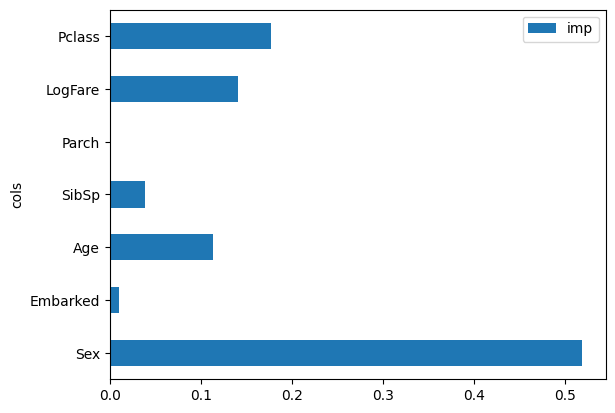

In [37]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');